# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

#env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

# Define Actor for DDPG
class Actor(nn.Module):
    def __init__(self, state_size, action_size, num_agent, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)        
        self.fc1 = nn.Linear(state_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x
    
# Define Critic for DDPG
class Critic(nn.Module):
    def __init__(self, state_size, action_size, num_agent, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)        
        self.fc1 = nn.Linear(state_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256+action_size, 128)
        self.fc3 = nn.Linear(128, 1)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        xs = F.relu(self.bn1(self.fc1(state)))
        x = torch.cat((xs, action), dim=1)        
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

In [6]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.5):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple(
            "Experience", 
            field_names=["state", "action", "reward", "next_state", "done"]
        )
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
EPS_START = 1.5
EPS_DECAY = 0.0001
EPS_FINAL = 0.1

class DDPGAgent:
    def __init__(
        self,
        agent_idx, state_size, action_size,
        num_agent,
        gamma, tau, batch_size, random_seed,
        eps_start=EPS_START,
        eps_decay=EPS_DECAY,
        eps_final=EPS_FINAL,
    ):
        self.agent_idx = agent_idx
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.seed = random.seed(random_seed)
        
        self.eps = eps_start
        self.eps_decay = eps_decay
        self.eps_final = eps_final

        # actor network
        self.actor = Actor(state_size, action_size, num_agent, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, num_agent, random_seed).to(device)
                           
        # critic network
        self.critic = Critic(state_size, action_size, num_agent, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, num_agent, random_seed).to(device)
        
        # hard copy
        self.soft_update(self.critic, self.critic_target, 1.)
        self.soft_update(self.actor, self.actor_target, 1.)                     

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_CRITIC)
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, self.batch_size, random_seed)
        
        # counter
        self.step_counter = 0
        
    def noise_reset(self):
        self.noise.reset()
        
    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()
        self.actor.train()
        
        if add_noise:
            action += self.eps * self.noise.sample()
            action = np.clip(action, -1, 1)
        return action
    
    def store(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
    def sample(self):
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            return experiences 
        return ()
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        action_next = self.actor_target(next_states)

        Q_targets_next = self.critic_target(next_states, action_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        Q_expected = self.critic(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor(states)
        actor_loss = -self.critic(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic, self.critic_target, self.tau)
        self.soft_update(self.actor, self.actor_target, self.tau)   
        
        # update noise decay parameter
        self.eps -= self.eps_decay
        self.eps = max(self.eps, self.eps_final)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

In [9]:
BUFFER_SIZE = int(1e6) # replay buffer size
BATCH_SIZE = 256 # minibatch size
GAMMA = 1 # discount factor
TAU = 1e-3 # for soft update of target parameters
NUM_EPISODES = 5000
LR_ACTOR = 1e-3
LR_CRITIC = 1e-3
WEIGHT_DECAY_CRITIC = 0
UPDATE_EVERY = 2
UPDATE_TIMES = 1
SEED = 1

In [11]:
def MADDPG(
    env, brain_name, 
    num_agent, state_size, action_size, 
    seed,
    gamma,
    tau,
    num_episodes, 
    batch_size,
):

    scores = []    
    scores_deque = deque(maxlen=100)
    agents = [
        DDPGAgent(0, state_size, action_size, num_agent, gamma, tau, batch_size, seed),
        DDPGAgent(1, state_size, action_size, num_agent, gamma, tau, batch_size, seed),
    ]

    step_counter = 0
    for i_episode in range(1, num_episodes+1):
        score = np.zeros(num_agent)
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations

        agents[0].noise_reset()
        agents[1].noise_reset()        
        
        while True:
            actions = []

            for idx in range(num_agent):
                state = np.expand_dims(states[idx], axis=0)
                actions += [agents[idx].act(state).squeeze()]
            
            actions = np.array(actions)
                
            # get next_state, reward, done
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards  
            next_states = env_info.vector_observations
            dones = env_info.local_done
            
            # store transition            
            for idx in range(num_agent):
                agents[0].store(states[idx], actions[idx], rewards[idx], next_states[idx], dones[idx])
                agents[1].store(states[idx], actions[idx], rewards[idx], next_states[idx], dones[idx])
            
            step_counter = (step_counter + 1) % UPDATE_EVERY
            if step_counter == 0:
                for idx in range(num_agent):
                    samples = agents[idx].sample()
                    if len(samples) > 0:
                        agents[idx].learn(samples)

            states = next_states            
            score += rewards
            if np.any(dones):
                break

        ep_max_score = np.max(score)
        scores.append(ep_max_score)
        scores_deque.append(ep_max_score)
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            for idx in range(num_agent):
                torch.save(agents[idx].actor.state_dict(), 'checkpoint_actor_{}.pth'.format(idx))
                torch.save(agents[idx].critic.state_dict(), 'checkpoint_critic_{}.pth'.format(idx))
            break            
        
    return scores, agents

In [12]:
scores, agents = MADDPG(
    env, brain_name, 
    num_agents, state_size, action_size, 
    SEED,
    GAMMA,
    TAU,
    NUM_EPISODES, 
    BATCH_SIZE,
)

Episode 100	Average Score: 0.0047
Episode 200	Average Score: 0.0133
Episode 300	Average Score: 0.0170
Episode 400	Average Score: 0.0220
Episode 500	Average Score: 0.0257
Episode 600	Average Score: 0.0403
Episode 700	Average Score: 0.0140
Episode 800	Average Score: 0.0018
Episode 900	Average Score: 0.0000
Episode 1000	Average Score: 0.0010
Episode 1100	Average Score: 0.0080
Episode 1200	Average Score: 0.0040
Episode 1300	Average Score: 0.0170
Episode 1400	Average Score: 0.0457
Episode 1500	Average Score: 0.0786
Episode 1600	Average Score: 0.1181
Episode 1700	Average Score: 0.1629
Episode 1800	Average Score: 0.1264
Episode 1900	Average Score: 0.1087
Episode 2000	Average Score: 0.1214
Episode 2100	Average Score: 0.3098
Episode 2154	Average Score: 0.5053
Environment solved in 2154 episodes!	Average Score: 0.51


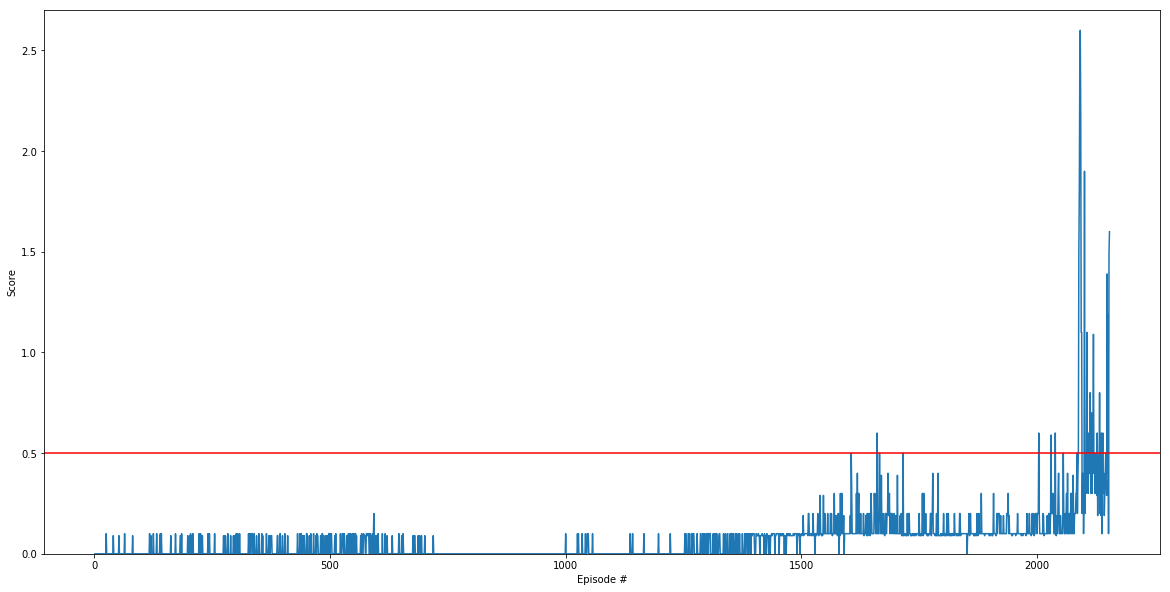

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig = plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.axhline(0.5, color='red')
plt.ylim([0, 2.7])
plt.show()

In [10]:
def run_trained_model(env, brain_name, state_size, action_size, num_agent):
    agents = [
        DDPGAgent(0, state_size, action_size, 2, GAMMA, TAU, BATCH_SIZE, 1),
        DDPGAgent(1, state_size, action_size, 2, GAMMA, TAU, BATCH_SIZE, 1),
    ]
    
    agents[0].actor.load_state_dict(torch.load('checkpoint_actor_0.pth', map_location={'cuda:0': 'cpu'}))
    agents[1].actor.load_state_dict(torch.load('checkpoint_actor_1.pth', map_location={'cuda:0': 'cpu'}))
    
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)

    while True:
        actions = []
        for idx in range(num_agent):
            state = np.expand_dims(states[idx], axis=0)
            actions += [agents[idx].act(state, add_noise=False).squeeze()]            
        actions = np.array(actions)
                                
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [13]:
run_trained_model(env, brain_name, state_size, action_size, 2)

Total score (averaged over agents) this episode: 2.650000039488077
